В этом блокноте мы будем использовать предварительно обученную модель глубокого обучения для обработки текста. Затем мы будем использовать выходные данные этой модели для классификации текста. Текст представляет собой список предложений из рецензий на фильмы. Мы будем классифицировать каждое предложение как «положительное» или «отрицательное» в отношении его темы.

Наша цель — создать модель, которая будет принимать предложение и выдавать либо 1 (положительное настроение), либо 0 (отрицательное настроение)

Здесь мы будем использовать предварительно обученную модель DistilBERT из библиотеки transformers. Самый простой способ использовать такую модель — это использовать pipeline.

In [14]:
from transformers import pipeline
import numpy as np
unmasker=pipeline('fill-mask', 'distilbert-base-uncased')
unmasker("I am in [MASK] and i love pizza")

[{'score': 0.0954817533493042,
  'token': 6014,
  'token_str': 'heaven',
  'sequence': 'i am in heaven and i love pizza'},
 {'score': 0.04710523039102554,
  'token': 2293,
  'token_str': 'love',
  'sequence': 'i am in love and i love pizza'},
 {'score': 0.03021743707358837,
  'token': 4199,
  'token_str': 'rome',
  'sequence': 'i am in rome and i love pizza'},
 {'score': 0.02034910023212433,
  'token': 3304,
  'token_str': 'italy',
  'sequence': 'i am in italy and i love pizza'},
 {'score': 0.019196968525648117,
  'token': 2793,
  'token_str': 'bed',
  'sequence': 'i am in bed and i love pizza'}]

Однако такой подход не очень гибок и, конечно, не позволяет точно настроить модель. По этой причине мы будем использовать модель вручную. Для этого мы загружаем модель и соответствующий токенизатор и используем их вместе. 

In [15]:
import torch
from transformers import DistilBertModel, DistilBertTokenizer, logging

logging.set_verbosity_error()
tokenizer= DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model =DistilBertModel.from_pretrained('distilbert-base-uncased')

text='Lorem ipsum dolor sit amet, consectetur adipiscing elit.'
tokenized_text=tokenizer(text, return_tensors='pt')

with torch.no_grad():
    output=model(**tokenized_text)
print(tokenizer.convert_ids_to_tokens(tokenized_text['input_ids'][0]))
output.last_hidden_state.shape

['[CLS]', 'lore', '##m', 'ip', '##sum', 'do', '##lor', 'sit', 'am', '##et', ',', 'con', '##se', '##ct', '##et', '##ur', 'adi', '##pis', '##cing', 'eli', '##t', '.', '[SEP]']


torch.Size([1, 23, 768])

In [16]:
tokenized_text=tokenizer(text)

for key, values in tokenized_text.items():
    values_type =type(values).__name__
    item_type = type(values[0]).__name__
    values_sample =f"[{', '.join(str(value) for value in values[:5])}, ...]"
    print(f"{key}: {values_type}[{item_type}], length {len(values)}: {values_sample}")

input_ids: list[int], length 23: [101, 19544, 2213, 12997, 17421, ...]
attention_mask: list[int], length 23: [1, 1, 1, 1, 1, ...]


In [17]:
print(f"Tokens: {tokenizer.convert_ids_to_tokens(tokenized_text['input_ids'])} ")
print(f"Decoded seuence {tokenizer.decode(tokenized_text['input_ids'])}")

Tokens: ['[CLS]', 'lore', '##m', 'ip', '##sum', 'do', '##lor', 'sit', 'am', '##et', ',', 'con', '##se', '##ct', '##et', '##ur', 'adi', '##pis', '##cing', 'eli', '##t', '.', '[SEP]'] 
Decoded seuence [CLS] lorem ipsum dolor sit amet, consectetur adipiscing elit. [SEP]


## Loading the dataset

In [18]:
import pandas as pd

dataset_url=('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv')
dataset=pd.read_csv(dataset_url, delimiter='\t', header=None)
dataset.columns= ['text', 'label']
dataset.head()

,text,label
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1


Выведем сколько предложений помечены как «положительные» (значение 1) и сколько — как «отрицательные» (значение 0)

In [19]:
dataset['label'].value_counts()

label
1    3610
0    3310
Name: count, dtype: int64

In [20]:
texts = dataset['text'].tolist()
labels = dataset['label'].values

Теперь нам нужно токенизировать наши тексты.

In [21]:
tokenized_texts=tokenizer(dataset['text'].tolist(), return_tensors='pt', padding=True)

for key, values in tokenized_texts.items():
  values_type=type(values).__name__
  print(f"{key}: {values_type}, {values.shape}")

input_ids: Tensor, torch.Size([6920, 67])
attention_mask: Tensor, torch.Size([6920, 67])


In [22]:
for key, values in tokenized_texts.items():
    values_type = type(values).__name__
    item_type = type(values[0]).__name__
    print(f"{key}:{values_type}[{item_type}], length{len(values)}")

input_ids:Tensor[Tensor], length6920
attention_mask:Tensor[Tensor], length6920


In [23]:
for seq in tokenized_texts["input_ids"][:5]:
    print(len(seq))

67
67
67
67
67


In [24]:
tokenized_texts["input_ids"]

tensor([[  101,  1037, 18385,  ...,     0,     0,     0],
        [  101,  4593,  2128,  ...,     0,     0,     0],
        [  101,  2027,  3653,  ...,     0,     0,     0],
        ...,
        [  101,  1996,  5896,  ...,     0,     0,     0],
        [  101,  1037,  5667,  ...,     0,     0,     0],
        [  101,  1037, 12090,  ...,     0,     0,     0]])

Проблема в том, что последовательности обычно имеют разную длину. Наиболее распространённым решением этой проблемы, часто используемым в NLP, является заполнение.
 И именно здесь в игру вступает «attention_mask». Она используется для того, чтобы маскировать заполнение

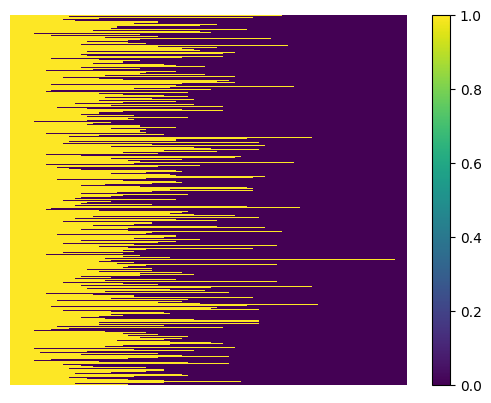

In [25]:
import matplotlib.pyplot as plt

plt.pcolormesh(tokenized_texts["attention_mask"])
plt.axis("off")
plt.colorbar()
plt.show()

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(np.__version__)


1.26.4


In [27]:
batch_size = 32
features = []
with torch.no_grad():
  # Модель энкодера DistillBert
    for i in range(0, len(texts), batch_size):
        texts_batch = tokenized_texts["input_ids"][i : i + batch_size].to(device)
        # print(texts_batch.shape)
        masks_batch = tokenized_texts["attention_mask"][i : i + batch_size].to(device)
        output = model(texts_batch, masks_batch)
        batch_features = output.last_hidden_state[:, 0, :].cpu().numpy() # Берем в каждом сэмпле CLS вектор длиной 768
        features.append(batch_features)


features = np.concatenate(features, axis=0) # Просто качественные эмбеддинги для классификации
features.shape

(6920, 768)

In [28]:
from sklearn.model_selection import train_test_split


train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

Теперь мы обучаем модель LogisticRegression.

In [29]:
import warnings

from sklearn.linear_model import LogisticRegression


warnings.simplefilter('ignore')  
lr_clf = LogisticRegression().fit(train_features, train_labels)

In [30]:
lr_clf.score(test_features, test_labels)

0.8369942196531792

Построим ROC curve

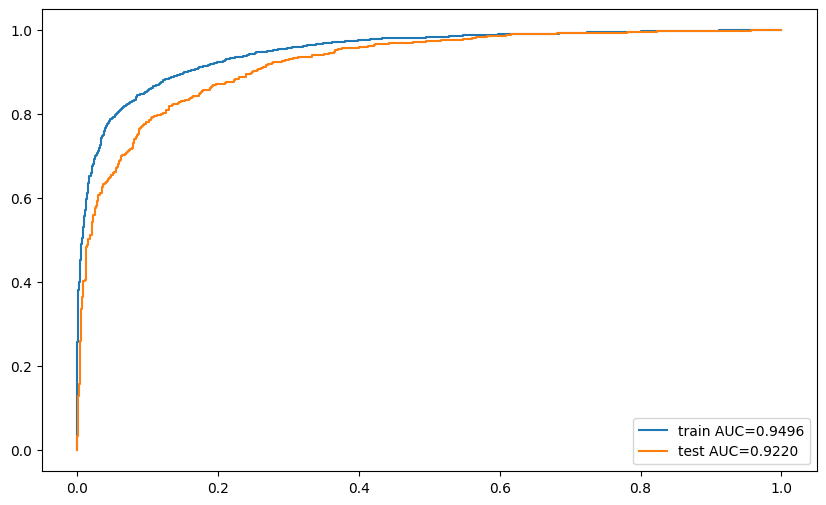

In [31]:
from sklearn.metrics import roc_auc_score, roc_curve


plt.figure(figsize=(10, 6))

proba = lr_clf.predict_proba(train_features)[:, 1] # Берем столбец вероятностей для метки 1
auc = roc_auc_score(train_labels, proba)
plt.plot(*roc_curve(train_labels, proba)[:2], label=f'train AUC={auc:.4f}')

proba = lr_clf.predict_proba(test_features)[:, 1]
auc = roc_auc_score(test_labels, proba)
plt.plot(*roc_curve(test_labels, proba)[:2], label=f'test AUC={auc:.4f}')

plt.legend()
plt.show()

In [32]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score


clf = DummyClassifier()
scores = cross_val_score(clf, train_features, train_labels)
print(f"Dummy classifier score: {scores.mean():.3f} (+/- {2 * scores.std():.3f})")

Dummy classifier score: 0.521 (+/- 0.001)


Наша модель дает лучшие результаты, чем Dummy classifier

Рассмотрим еще один такой же пример

In [33]:
import pandas as pd
dataset_url = 'https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/comments_small_dataset/comments.tsv'
dataset = pd.read_csv(dataset_url, sep='\t')
print(dataset.shape)
dataset.head()

(1000, 2)


,should_ban,comment_text
0,0,The picture on the article is not of the actor...
1,1,"Its madness. Shes of Chinese heritage, but JAP..."
2,1,Fuck You. Why don't you suck a turd out of my ...
3,1,God is dead\nI don't mean to startle anyone bu...
4,1,THIS USER IS A PLANT FROM BRUCE PERENS AND GRO...


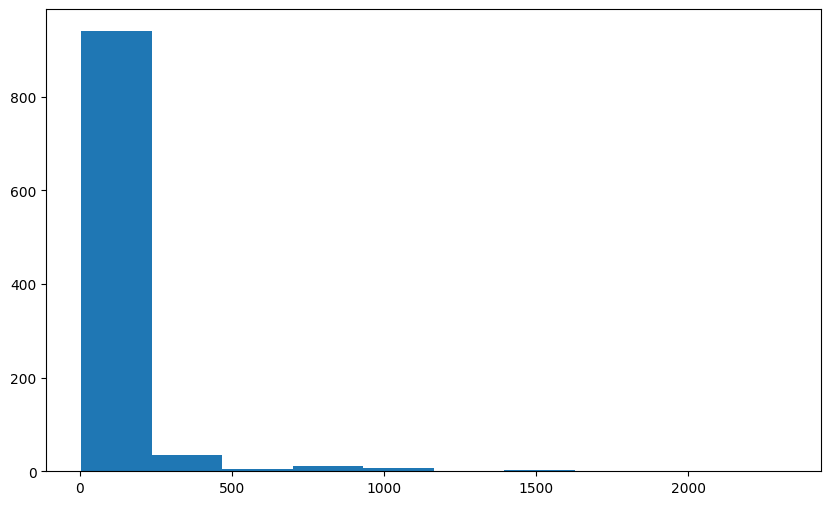

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from transformers import pipeline
import torch
from transformers import DistilBertModel, DistilBertTokenizer, logging
import matplotlib.pyplot as plt


tokenizer=DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model=DistilBertModel.from_pretrained('distilbert-base-uncased')

texts = dataset["comment_text"].tolist()
labels=dataset['should_ban'].tolist()
tokenized_texts = tokenizer(texts)
ids_lens = list(len(toks) for toks in tokenized_texts["input_ids"])

plt.figure(figsize=(10, 6))
plt.hist(ids_lens)
plt.show()

In [35]:
print(tokenized_texts)

{'input_ids': [[101, 1996, 3861, 2006, 1996, 3720, 2003, 2025, 1997, 1996, 3364, 1056, 1012, 1054, 1012, 5000, 2040, 2003, 1996, 3395, 1997, 1996, 3720, 1012, 2130, 1037, 3937, 8224, 3945, 4332, 2039, 4620, 1997, 1996, 1056, 1012, 1054, 1012, 5000, 2055, 2029, 2023, 3720, 2003, 2517, 1012, 1996, 6302, 14678, 2108, 2794, 2000, 1996, 3720, 2003, 1010, 2153, 1010, 2025, 1037, 6302, 1997, 2023, 3720, 1005, 1055, 3395, 1012, 2138, 2023, 6302, 2003, 2025, 7882, 2000, 1996, 3395, 1997, 1996, 3720, 1010, 2009, 2323, 1998, 2097, 2022, 3718, 1012, 2077, 2026, 10086, 2030, 2216, 1997, 2500, 2040, 2031, 2081, 1996, 2168, 10086, 2024, 16407, 1010, 3531, 3073, 1037, 11476, 3114, 2005, 2023, 3746, 1005, 1055, 10502, 1999, 2023, 3720, 1012, 2065, 1037, 4189, 1011, 2224, 3746, 1997, 1056, 1012, 1054, 1012, 5000, 1010, 1996, 3364, 1998, 3395, 1997, 2023, 3720, 1010, 2064, 2022, 2179, 1010, 2059, 2011, 2035, 2965, 2009, 2064, 2022, 2794, 1010, 2021, 6721, 4871, 2323, 2025, 2022, 2109, 2004, 2173, 17794, 

### Отсортируем сэмплы по длине последовательности

In [36]:
def sorted_texts(tokenized_texts, labels):
  values_emb=list(tokenized_texts.values())[0]
  maskes=list(tokenized_texts.values())[1]

  sorted_values_labels=sorted(zip(values_emb,labels), key=lambda x: len(x[0]), reverse=True) # отсортированные значения inputs_ids по длине
  sorted_values, labels = zip(*sorted_values_labels)
  sorted_maskes=sorted(maskes, key=lambda x: len(x), reverse=True)

  list_i=[]
  for i, (x, y) in enumerate(zip(sorted_values,sorted_maskes)):

    if len(x)>500 and len(y)>500:
        list_i.append(i)

  sorted_values=np.array(sorted_values, dtype=object)
  sorted_maskes=np.array(sorted_maskes, dtype=object)
  labels=np.array(labels, dtype=object)

  sorted_values=np.delete(sorted_values, list_i)
  sorted_maskes=np.delete(sorted_maskes, list_i)
  labels=np.delete(labels, list_i).tolist()

  tokenized_texts={'input_ids':sorted_values, 'attention_mask':sorted_maskes}

  return tokenized_texts, labels

tokenized_texts_sort, labels=sorted_texts(tokenized_texts, labels)
print(len(tokenized_texts_sort['input_ids'][0]))
print(len(labels))

444
975


In [37]:
batch_size=32
len_seq_batch=len(tokenized_texts_sort['input_ids'])
len_seq_batch

975

In [38]:
import numpy as np
model.to(device)
batch_size=32
features = []
from torch.nn.utils.rnn import pad_sequence
with torch.no_grad():
    for i in range(0, len(tokenized_texts_sort['input_ids']), batch_size):

        texts_batch =tokenized_texts_sort["input_ids"][i : i + batch_size]
        texts_batch_tensor=[torch.tensor(text) for text in texts_batch]
        texts_padded = pad_sequence(texts_batch_tensor, batch_first=False, padding_value=1).to(device)
        # print(texts_padded.shape)

        masks_batch = tokenized_texts_sort["attention_mask"][i : i + batch_size]
        masks_batch_tensor=[torch.tensor(text) for text in masks_batch]
        maskes_padded = pad_sequence(masks_batch_tensor,batch_first=False, padding_value=0).to(device)

        texts_padded=texts_padded.permute(1,0)
        maskes_padded=maskes_padded.permute(1,0)

        output = model(texts_padded, maskes_padded)
        batch_features = output.last_hidden_state[:, 0, :].cpu().numpy() # Берем [все батчи, вектор cls, длина эмбеддинга]
        features.append(batch_features)

features = np.concatenate(features, axis=0)

features.shape

(975, 768)

### Разделим на train и test

In [39]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels=train_test_split(features, labels)

In [40]:
import warnings

from sklearn.linear_model import LogisticRegression
warnings.simplefilter('ignore')

lgr=LogisticRegression()
lcf_fit=lgr.fit(train_features, train_labels)

In [41]:
lcf_fit.score(test_features, test_labels)

0.8442622950819673

### Построим ROC-CURVE

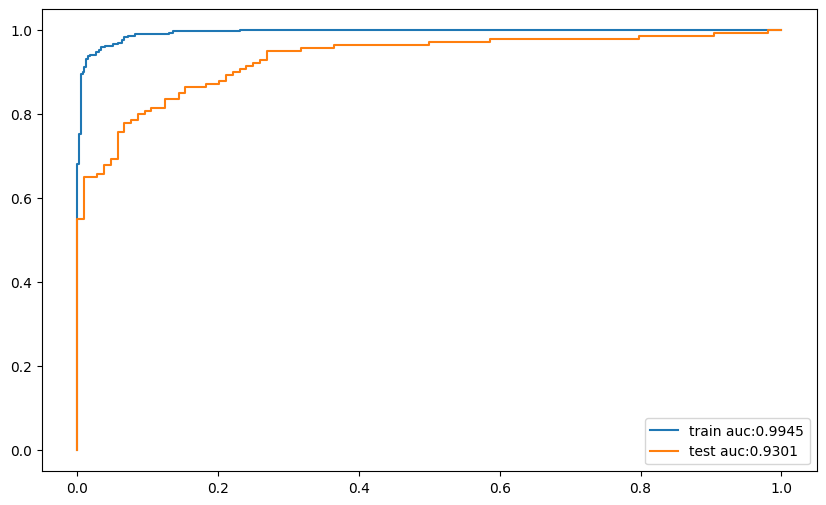

In [42]:
from sklearn.metrics import roc_auc_score, roc_curve

plt.figure(figsize=(10,6))
proba=lcf_fit.predict_proba(train_features)[:,1] # Берем первый столбец для меток 1
auc=roc_auc_score(train_labels, proba)
plt.plot(*roc_curve(train_labels, proba)[:2], label=f"train auc:{auc:.4f}")


proba_test=lcf_fit.predict_proba(test_features)[:,1]
auc_test=roc_auc_score(test_labels, proba_test)
plt.plot(*roc_curve(test_labels, proba_test)[:2], label=f"test auc:{auc_test:.4f}")
plt.legend()
plt.show()

### Наша модель довольно неплоха, по крайнем мере она лучше Dummy

In [44]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score


clf = DummyClassifier()
scores = cross_val_score(clf, train_features, train_labels)
print(f"Dummy classifier score: {scores.mean():.3f} (+/- {2 * scores.std():.3f})")

Dummy classifier score: 0.514 (+/- 0.003)
